# Property Sales

This data comes from the Annualized Rolling Sales dataset on NYC Open Data:

https://data.cityofnewyork.us/Housing-Development/Annualized-Rolling-Sales-Update/uzf5-f8n2

This notebook also utilizes PLUTO data, which has not been uploaded but can be found here:

https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page

In [1]:
import urllib.request
import PyPDF2
import pandas as pd
import matplotlib.pylab as plt
import zipfile

In [2]:
# Uncomment if you need to run these cells again
# url = 'https://data.cityofnewyork.us/api/views/uzf5-f8n2/files/8d9ba1d7-9b7a-43de-b741-bd9a35839e03?filename' + \
    # '=Annualized%20Rolling%20Sales%20Update.zip'
# urllib.request.urlretrieve(url, 'rolling_sales.zip')
# !mkdir data/primary_source_data/rolling_sales
# !unzip rolling_sales.zip -d data/primary_source_data/rolling_sales
# !rm -r rolling_sales.zip

In [3]:
# Get a list of all the downloaded files
!ls data/primary_source_data/rolling_sales

2009_bronx.xls              2015_queens.xls
2009_brooklyn.xls           2015_statenisland.xls
2009_manhattan.xls          glossary_rsf071607.pdf
2009_queens.xls             sales_2007_bronx.xls
2009_statenisland.xls       sales_2007_brooklyn.xls
2010_bronx.xls              sales_2007_manhattan.xls
2010_brooklyn.xls           sales_2007_queens.xls
2010_manhattan.xls          sales_2007_statenisland.xls
2010_queens.xls             sales_2008_bronx.xls
2010_statenisland.xls       sales_2008_brooklyn.xls
2011_bronx.xls              sales_2008_manhattan.xls
2011_brooklyn.xls           sales_2008_queens.xls
2011_manhattan.xls          sales_2008_statenisland.xls
2011_queens.xls             sales_bronx_03.xls
2011_statenisland.xls       sales_bronx_04.xls
2012_bronx.xls              sales_bronx_05.xls
2012_brooklyn.xls           sales_bronx_06.xls
2012_manhattan.xls          sales_brooklyn_03.xls
2012_queens.xls             sales_brooklyn_04.xls
2012_statenisland.xls       sales_brooklyn_05.x

## Reading the glossary PDF
   
I used the PyPDF2 library to read this PDF.

In [4]:
gloss = PyPDF2.PdfFileReader('data/primary_source_data/rolling_sales/glossary_rsf071607.pdf')

In [5]:
for i in range(gloss.getNumPages()):
    print("Page {}:".format(i))
    print("")
    print(gloss.getPage(i).extractText())
    print("")

Page 0:

        I. GLOSSARY OF TERMS 
 II.     HOW TO POWER SORT FROM EXCEL 
Glossary of Terms for Property Sales Files  I. GLOSSARY OF TERMS The following terms follow the column headings across the spreadsheet, from left to right.   Borough:  The name of the borough in which the property is located.  Neighborhood: Department of Finance assessors determine the neighborhood name in the course of valuing properties. The common name of the neighborhood is generally the same as the name Finance designates. However, there may be slight differences in neighborhood boundary lines and some sub-neighborhoods may not be included.  Building Class Category: 
This is a field that we are including so that users of the Rolling Sales Files can easily identify similar properties by broad usage (e.g. One Family Homes) without looking up individual Building Classes. Files are sorted by Borough, Neighborhood, Building Class Category, Block and Lot.  Tax Class at Present: Every property in the city is as

# Brooklyn data

I checked the columns for all the data between 2009 and 2015 and they all share the same column names (once you strip whitespace), allowing these dataframes to be merged without losing any data.

In [33]:
bk_dfs = []
# Used separate skiprows values since Excel files were formatted slightly differently
for i in range(3,7): # For the years 2003 to 2006
    temp_df = pd.read_excel('data/primary_source_data/rolling_sales/sales_brooklyn_0{}.xls'.format(i), skiprows=3)
    temp_df.rename(columns=lambda x: x.strip(), inplace=True)
    bk_dfs.append(temp_df)
for i in range(2007,2009): # For 2007 and 2008
    temp_df = pd.read_excel('data/primary_source_data/rolling_sales/sales_{}_brooklyn.xls'.format(i), skiprows=3)
    temp_df.rename(columns=lambda x: x.strip(), inplace=True)
    bk_dfs.append(temp_df)
for i in range(2009, 2011): # For 2009 and 2010
    temp_df = pd.read_excel('data/primary_source_data/rolling_sales/{}_brooklyn.xls'.format(i), skiprows=3)
    temp_df.rename(columns=lambda x: x.strip(), inplace=True)
    bk_dfs.append(temp_df)
for i in range(2011, 2016): # For 2011 to 2015
    temp_df = pd.read_excel('data/primary_source_data/rolling_sales/{}_brooklyn.xls'.format(i), skiprows=4)
    temp_df.rename(columns=lambda x: x.strip(), inplace=True)
    bk_dfs.append(temp_df)

In [34]:
# Combine the data
bk_df = pd.concat(bk_dfs)
bk_df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,3,BATH BEACH,01 ONE FAMILY HOMES,1,6363,38,,B3,1602 86 STREET,,...,2,0,2,1439,2090,1901,1,A5,0,2003-08-01
1,3,BATH BEACH,01 ONE FAMILY HOMES,1,6364,45,,S1,1652 86 STREET,,...,1,1,2,1200,1620,1926,1,S1,450000,2003-01-24
2,3,BATH BEACH,01 ONE FAMILY HOMES,1,6365,44,,S1,1690 86 STREET,,...,1,1,2,1473,1656,1931,1,S1,0,2003-10-08
3,3,BATH BEACH,01 ONE FAMILY HOMES,1,6365,44,,S1,1690 86 STREET,,...,1,1,2,1473,1656,1931,1,S1,0,2003-04-02
4,3,BATH BEACH,01 ONE FAMILY HOMES,1,6365,143,,S1,1686 86 STREET,,...,1,1,2,1473,1656,1929,1,S1,0,2003-04-02


In [9]:
# Remove the sales with Sale Price 0 (these are special situations like transfers to family members)
bk_df_nz = bk_df[bk_df['SALE PRICE'] != 0]
bk_df_nz = bk_df_nz[bk_df_nz['LAND SQUARE FEET'] != 0]
bk_df_nz = bk_df_nz[bk_df_nz['GROSS SQUARE FEET'] != 0]

In [10]:
# Create columns with sale price per square feet
bk_df_nz['price_per_lsf'] = bk_df_nz['SALE PRICE']/bk_df_nz['LAND SQUARE FEET']
bk_df_nz['price_per_gsf'] = bk_df_nz['SALE PRICE']/bk_df_nz['GROSS SQUARE FEET']

## Grouping data by time

To prepare the data for grouping by time, I created a new dataframe indexed by the sale date. Then I created a separate dataframe for Red Hook sales only.

In [11]:
# All Brooklyn sales indexed by the sale date
bk_groups = bk_df_nz.set_index('SALE DATE')
bk_groups.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,price_per_lsf,price_per_gsf
SALE DATE,,,,,,,,,,,,,,,,,,,,,
2003-01-24,3,BATH BEACH,01 ONE FAMILY HOMES,1,6364,45,,S1,1652 86 STREET,,...,1,2,1200,1620,1926,1,S1,450000,375.000000,277.777778
2003-02-27,3,BATH BEACH,01 ONE FAMILY HOMES,1,6393,16,,A5,145 BAY 8 STREET,,...,0,1,1716,1554,1920,1,A5,320000,186.480186,205.920206
2003-06-17,3,BATH BEACH,01 ONE FAMILY HOMES,1,6395,20,,A5,135 BAY 10 STREET,,...,0,1,2417,2000,1935,1,A5,427500,176.872156,213.750000
2003-07-21,3,BATH BEACH,01 ONE FAMILY HOMES,1,6399,104,,S1,1663 BATH AVENUE,,...,1,2,1260,1908,1930,1,S1,355000,281.746032,186.058700
2003-11-20,3,BATH BEACH,01 ONE FAMILY HOMES,1,6402,1,,S1,1769 BATH AVENUE,,...,1,2,1000,1918,1920,1,S1,3307131,3307.131000,1724.260167


In [12]:
"""
Grouping all Brooklyn sales by the month of the sale date and taking the mean of each column (including 
sale price)
"""
bk_mm = bk_groups.resample('M').mean()
bk_mm.reset_index(inplace=True)
bk_mm.head()

,SALE DATE,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,price_per_lsf,price_per_gsf
0,2003-01-31,3.0,4532.444946,45.966606,11220.674188,3.074910,0.180505,3.255415,2747.025271,3659.879964,1925.996390,1.340253,421674.826715,166.497850,146.584837
1,2003-02-28,3.0,4512.802831,48.642063,11220.878665,3.797776,0.147624,3.945399,3052.362993,4408.152679,1931.105157,1.289181,414711.939333,169.723528,150.080743
2,2003-03-31,3.0,4446.894691,40.651001,11220.111401,3.041775,0.206266,3.248042,2785.549173,3652.063534,1927.756310,1.356832,419894.069626,166.075849,1704.556626
3,2003-04-30,3.0,4308.347426,46.871324,11220.296875,3.296875,0.153493,3.450368,2688.589154,3861.026654,1929.437500,1.315257,371891.053309,162.847248,493.591983
4,2003-05-31,3.0,4404.325083,54.524752,11220.015677,3.773927,0.182343,3.956271,2972.397690,4460.961221,1927.905116,1.372112,456311.102310,169.318052,222.923790


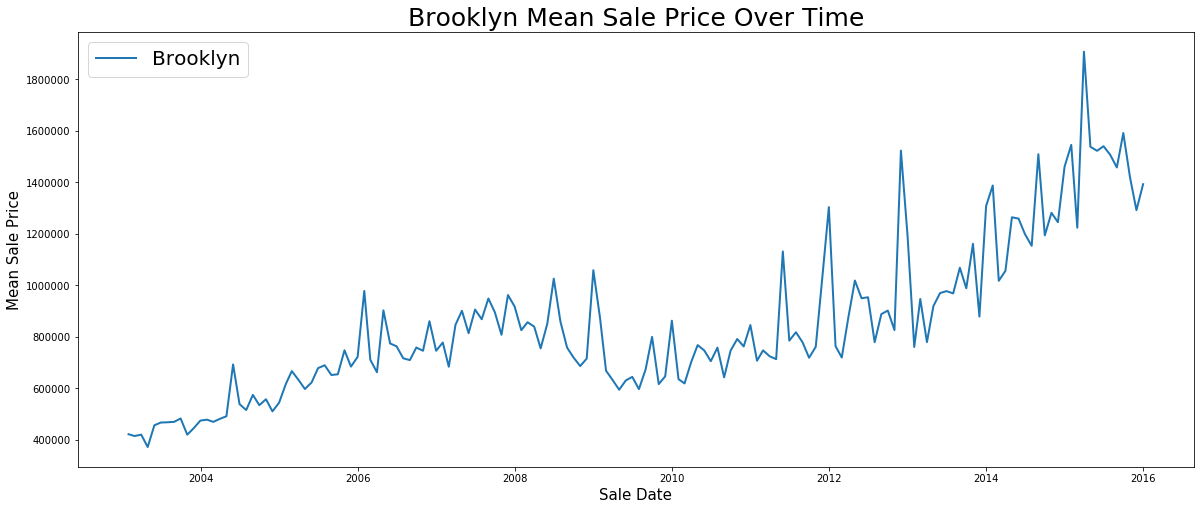

In [13]:
# Mean sale price of all buildings in Brooklyn
plt.figure(figsize=(20,8))
plt.plot(bk_mm['SALE DATE'], bk_mm['SALE PRICE'], alpha=1,linewidth=2,label='Brooklyn')
plt.title("Brooklyn Mean Sale Price Over Time", fontsize=25)
plt.xlabel("Sale Date", fontsize=15)
plt.ylabel("Mean Sale Price", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

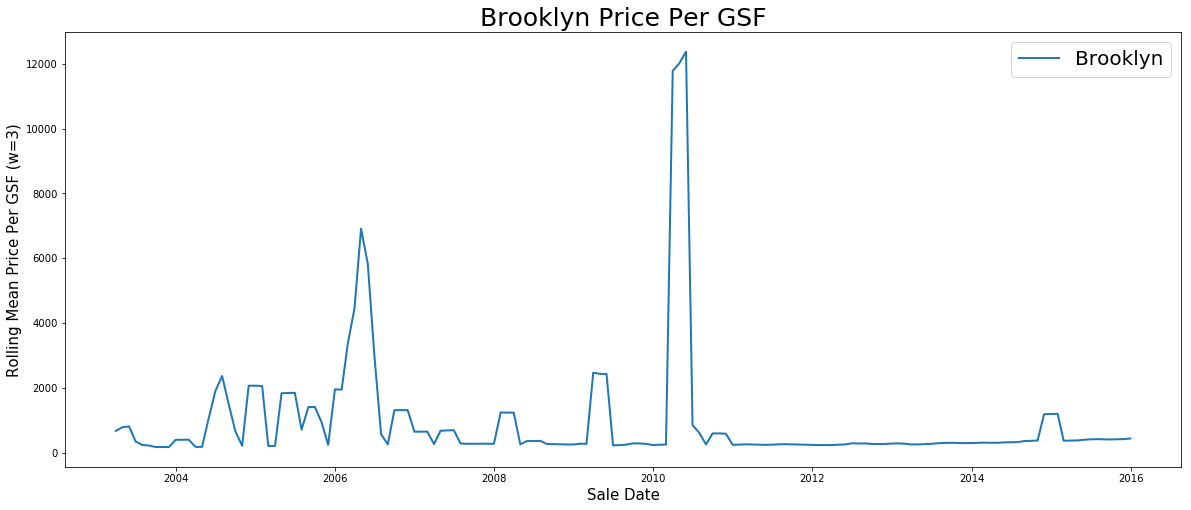

In [14]:
# Mean price per GSF of all buildings in Brooklyn
plt.figure(figsize=(20,8))
plt.plot(bk_mm['SALE DATE'], bk_mm['price_per_gsf'].rolling(3).mean(), alpha=1,linewidth=2,label='Brooklyn')
plt.title("Brooklyn Price Per GSF", fontsize=25)
plt.xlabel("Sale Date", fontsize=15)
plt.ylabel("Rolling Mean Price Per GSF (w=3)", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

## Red Hook only

In [15]:
pluto = pd.read_csv('data/primary_source_data/pluto_18v2_1.csv')
pluto.head()

,borough,block,lot,cd,ct2010,cb2010,schooldist,council,zipcode,firecomp,...,firm07_flag,pfirm15_flag,rpaddate,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate
0,BX,5641.0,670.0,210.0,516.0,2.0,NaN,13.0,NaN,NaN,...,1.0,1.0,12/6/2018,12/20/2018,12/21/2018,12/20/2018,12/21/2018,NaN,NaN,12/20/2018
1,QN,3935.0,3.0,407.0,929.0,1001.0,25.0,19.0,11356.0,E297,...,NaN,NaN,12/6/2018,12/20/2018,12/21/2018,12/20/2018,12/21/2018,NaN,NaN,12/20/2018
2,BX,4205.0,41.0,211.0,296.0,2000.0,11.0,13.0,NaN,Q061,...,NaN,NaN,12/6/2018,12/20/2018,12/21/2018,12/20/2018,12/21/2018,NaN,NaN,12/20/2018
3,BX,2402.0,14.0,201.0,69.0,2005.0,7.0,17.0,NaN,L055,...,NaN,NaN,12/6/2018,12/20/2018,12/21/2018,12/20/2018,12/21/2018,NaN,NaN,12/20/2018
4,SI,63.0,83.0,501.0,81.0,2006.0,31.0,49.0,10301.0,E155,...,NaN,NaN,12/6/2018,12/20/2018,12/21/2018,12/20/2018,12/21/2018,NaN,NaN,12/20/2018


In [22]:
bk_df_nz.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,price_per_lsf,price_per_gsf
1,3,BATH BEACH,01 ONE FAMILY HOMES,1,6364,45,,S1,1652 86 STREET,,...,2,1200,1620,1926,1,S1,450000,2003-01-24,375.000000,277.777778
9,3,BATH BEACH,01 ONE FAMILY HOMES,1,6393,16,,A5,145 BAY 8 STREET,,...,1,1716,1554,1920,1,A5,320000,2003-02-27,186.480186,205.920206
10,3,BATH BEACH,01 ONE FAMILY HOMES,1,6395,20,,A5,135 BAY 10 STREET,,...,1,2417,2000,1935,1,A5,427500,2003-06-17,176.872156,213.750000
15,3,BATH BEACH,01 ONE FAMILY HOMES,1,6399,104,,S1,1663 BATH AVENUE,,...,2,1260,1908,1930,1,S1,355000,2003-07-21,281.746032,186.058700
18,3,BATH BEACH,01 ONE FAMILY HOMES,1,6402,1,,S1,1769 BATH AVENUE,,...,2,1000,1918,1920,1,S1,3307131,2003-11-20,3307.131000,1724.260167


In [16]:
# Join PLUTO and property sales data - thanks Ben
def format_bbl(parcel):
    borough = str(parcel['BOROUGH'])
    block = str(parcel['BLOCK'])
    lot = str(parcel['LOT'])
    return int(borough + block.zfill(5) + lot.zfill(4))

In [23]:
# Create bbls
bk_df_nz['BBL'] = bk_df_nz.apply(format_bbl, axis=1)

In [24]:
# Merge so we can check census tract numbers
bk_pluto = bk_df_nz.merge(pluto, how='left', left_on='BBL', right_on='bbl')
bk_pluto.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,firm07_flag,pfirm15_flag,rpaddate,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate
0,3,BATH BEACH,01 ONE FAMILY HOMES,1,6364,45,,S1,1652 86 STREET,,...,NaN,NaN,12/6/2018,12/20/2018,12/21/2018,12/20/2018,12/21/2018,NaN,NaN,12/20/2018
1,3,BATH BEACH,01 ONE FAMILY HOMES,1,6393,16,,A5,145 BAY 8 STREET,,...,NaN,NaN,12/6/2018,12/20/2018,12/21/2018,12/20/2018,12/21/2018,NaN,NaN,12/20/2018
2,3,BATH BEACH,01 ONE FAMILY HOMES,1,6395,20,,A5,135 BAY 10 STREET,,...,NaN,NaN,12/6/2018,12/20/2018,12/21/2018,12/20/2018,12/21/2018,NaN,NaN,12/20/2018
3,3,BATH BEACH,01 ONE FAMILY HOMES,1,6399,104,,S1,1663 BATH AVENUE,,...,NaN,NaN,12/6/2018,12/20/2018,12/21/2018,12/20/2018,12/21/2018,NaN,NaN,12/20/2018
4,3,BATH BEACH,01 ONE FAMILY HOMES,1,6402,1,,S1,1769 BATH AVENUE,,...,NaN,NaN,12/6/2018,12/20/2018,12/21/2018,12/20/2018,12/21/2018,NaN,NaN,12/20/2018


In [25]:
# Filter down to sales we're interested in using census tracts 53, 59, and 85
rh = bk_pluto[(bk_pluto.tract2010==53) | (bk_pluto.tract2010==59 | \
                                          (bk_pluto.tract2010==85))]
rh.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,firm07_flag,pfirm15_flag,rpaddate,dcasdate,zoningdate,landmkdate,basempdate,masdate,polidate,edesigdate
2990,3,BROOKLYN HEIGHTS,01 ONE FAMILY HOMES,1,225,114,,A5,38 ORANGE STREET,,...,NaN,NaN,12/6/2018,12/20/2018,12/21/2018,12/20/2018,12/21/2018,NaN,NaN,12/20/2018
2997,3,BROOKLYN HEIGHTS,02 TWO FAMILY HOMES,1,210,19,,B9,33 MIDDAGH STREET,,...,NaN,NaN,12/6/2018,12/20/2018,12/21/2018,12/20/2018,12/21/2018,NaN,NaN,12/20/2018
2998,3,BROOKLYN HEIGHTS,02 TWO FAMILY HOMES,1,214,25,,B3,11 CRANBERRY STREET,,...,NaN,NaN,12/6/2018,12/20/2018,12/21/2018,12/20/2018,12/21/2018,NaN,NaN,12/20/2018
3005,3,BROOKLYN HEIGHTS,03 THREE FAMILY HOMES,1,216,38,,C0,65 CRANBERRY STREET,,...,NaN,NaN,12/6/2018,12/20/2018,12/21/2018,12/20/2018,12/21/2018,NaN,NaN,12/20/2018
3010,3,BROOKLYN HEIGHTS,07 RENTALS - WALKUP APARTMENTS,2B,215,3,,C1,29 WILLOW STREET,10,...,NaN,NaN,12/6/2018,12/20/2018,12/21/2018,12/20/2018,12/21/2018,NaN,NaN,12/20/2018


In [26]:
print("Number of sales in study area: {}".format(rh.shape[0]))

Number of sales in study area: 396


In [29]:
"""
Grouping all Red Hook sales by the month of the sale date and taking the mean of each column (including 
sale price).
"""
rh_groups = rh.set_index('SALE DATE')
rh_mm = rh_groups.resample('M').mean()
rh_mm.reset_index(inplace=True)
rh_mm.head()

,SALE DATE,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,...,ycoord,appbbl,mappluto_f,plutomapid,sanitdistrict,healthcenterdistrict,firm07_flag,pfirm15_flag,masdate,polidate
0,2003-01-31,3.0,543.000000,14.000000,11231.000000,1.000000,1.000000,2.000000,24833.333333,12681.333333,...,185432.333333,0.000000e+00,NaN,1.0,6.000000,38.0,1.0,1.0,NaN,NaN
1,2003-02-28,3.0,563.200000,20.600000,11231.000000,0.800000,0.600000,1.400000,1518.000000,1294.400000,...,185005.800000,0.000000e+00,NaN,1.0,6.000000,38.0,1.0,1.0,NaN,NaN
2,2003-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003-04-30,3.0,519.857143,25.428571,11226.714286,1.428571,0.285714,1.714286,2940.428571,2417.428571,...,187004.714286,4.293600e+08,NaN,1.0,5.428571,38.0,1.0,1.0,NaN,NaN
4,2003-05-31,3.0,490.750000,18.750000,11223.500000,4.000000,0.000000,4.000000,2180.000000,3269.000000,...,187859.750000,0.000000e+00,NaN,1.0,5.000000,38.0,1.0,1.0,NaN,NaN


In [30]:
rh_mm.describe()

,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,...,ycoord,appbbl,mappluto_f,plutomapid,sanitdistrict,healthcenterdistrict,firm07_flag,pfirm15_flag,masdate,polidate
count,137.0,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,1.370000e+02,0.0,137.000000,137.000000,137.0,103.0,113.0,0.0,0.0
mean,3.0,490.207485,24.099774,11223.883299,3.584918,0.427590,4.012507,10639.340977,10760.426857,1920.265676,...,187678.556986,4.053399e+08,NaN,1.007299,5.051106,38.0,1.0,1.0,NaN,NaN
std,0.0,113.950331,15.121513,9.645857,7.189956,0.568479,7.197429,38772.629164,25742.369140,33.535785,...,2762.551934,7.783043e+08,NaN,0.085436,1.286114,0.0,0.0,0.0,NaN,NaN
min,3.0,214.000000,1.000000,11201.000000,0.000000,0.000000,1.000000,815.000000,1020.000000,1826.000000,...,184379.500000,0.000000e+00,NaN,1.000000,2.000000,38.0,1.0,1.0,NaN,NaN
25%,3.0,408.750000,14.666667,11216.000000,1.000000,0.000000,1.500000,1869.000000,2480.000000,1901.000000,...,185580.333333,0.000000e+00,NaN,1.000000,4.000000,38.0,1.0,1.0,NaN,NaN
50%,3.0,546.000000,21.500000,11231.000000,2.000000,0.333333,2.000000,2259.625000,3388.222222,1918.333333,...,186341.000000,0.000000e+00,NaN,1.000000,6.000000,38.0,1.0,1.0,NaN,NaN
75%,3.0,576.428571,29.000000,11231.000000,3.000000,0.666667,3.500000,4400.000000,5822.500000,1931.000000,...,189311.500000,5.009967e+08,NaN,1.000000,6.000000,38.0,1.0,1.0,NaN,NaN
max,3.0,608.500000,101.000000,11231.000000,62.333333,5.000000,63.166667,420209.800000,222738.000000,2008.000000,...,194404.666667,3.005880e+09,NaN,2.000000,6.000000,38.0,1.0,1.0,NaN,NaN


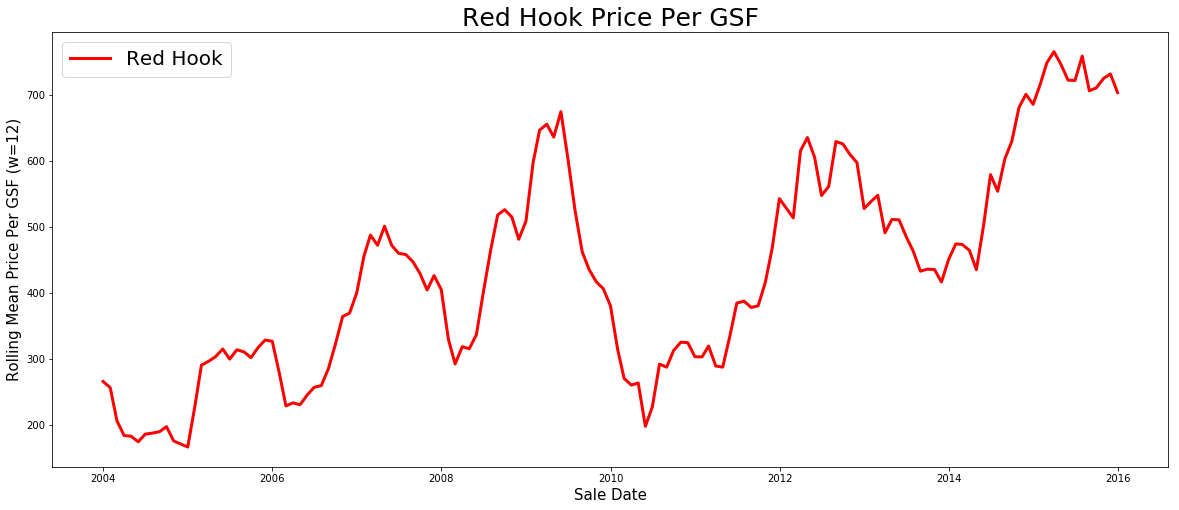

In [31]:
# Mean sale price of all buildings in Red Hook
plt.figure(figsize=(20,8))
# Interpolate since not all months in Red Hook had sales and otherwise render as missing
plt.plot(rh_mm.interpolate(method='linear')['SALE DATE'], \
         rh_mm.interpolate(method='linear')['price_per_gsf'].rolling(12).mean(), \
         c='r', alpha=1,linewidth=3,label='Red Hook')
plt.title("Red Hook Price Per GSF", fontsize=25)
plt.xlabel("Sale Date", fontsize=15)
plt.ylabel("Rolling Mean Price Per GSF (w=12)", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

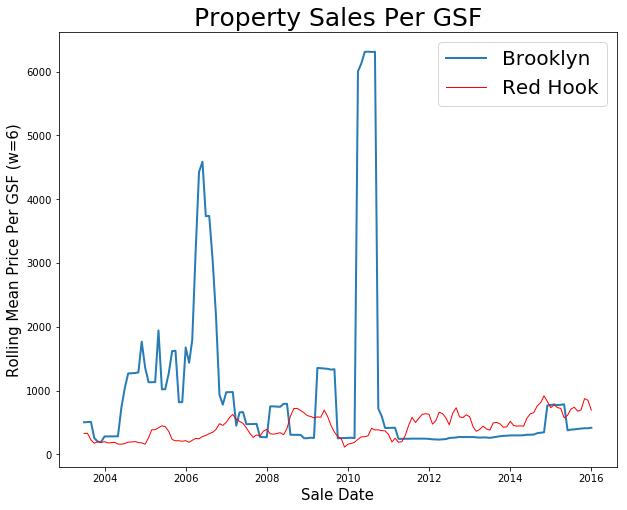

In [32]:
# Mean sale price of all buildings in Red Hook
plt.figure(figsize=(10,8))
plt.plot(bk_mm['SALE DATE'], bk_mm['price_per_gsf'].rolling(6).mean(), alpha=10,linewidth=2,label='Brooklyn')
# Interpolate since not all months in Red Hook had sales and otherwise render as missing
plt.plot(rh_mm.interpolate(method='linear')['SALE DATE'], \
         rh_mm.interpolate(method='linear')['price_per_gsf'].rolling(6).mean(), c='r', \
         alpha=1,linewidth=1,label='Red Hook')
plt.title("Property Sales Per GSF", fontsize=25)
plt.xlabel("Sale Date", fontsize=15)
plt.ylabel("Rolling Mean Price Per GSF (w=6)", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

# Counts

Count of the number of sales per month.

In [35]:
bk_mc = bk_groups.resample('M').count()
bk_mc.reset_index(inplace=True)
rh_mc = rh_groups.resample('M').count()
rh_mc.reset_index(inplace=True)

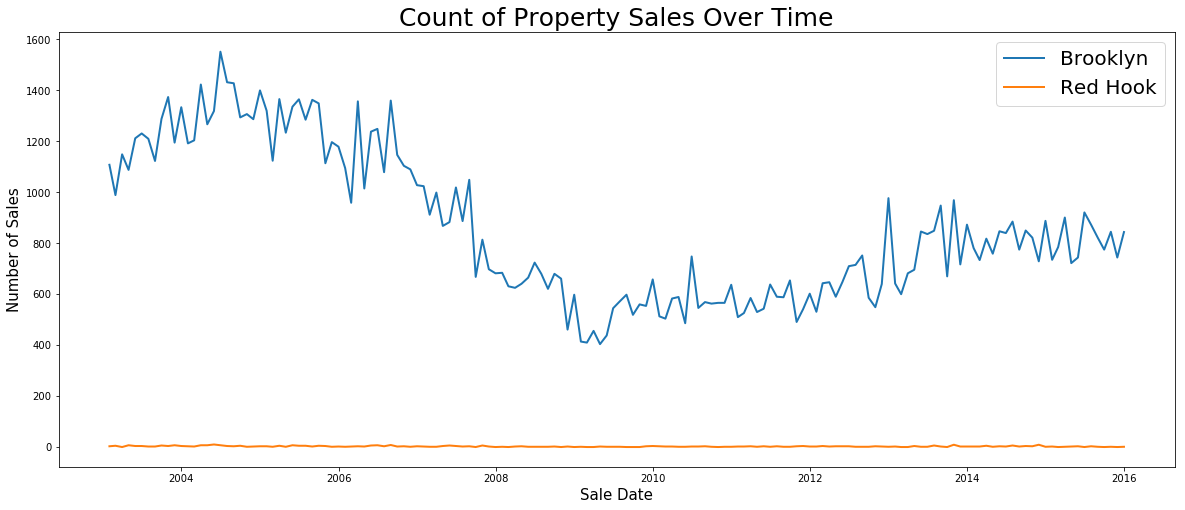

In [36]:
plt.figure(figsize=(20,8))
plt.plot(bk_mc['SALE DATE'], bk_mc['SALE PRICE'], alpha=1,linewidth=2,label='Brooklyn')
plt.plot(rh_mc['SALE DATE'], rh_mc['SALE PRICE'], alpha=1,linewidth=2,label='Red Hook')
plt.title("Count of Property Sales Over Time", fontsize=25)
plt.xlabel("Sale Date", fontsize=15)
plt.ylabel("Number of Sales", fontsize=15)
plt.legend(prop={'size': 20})
plt.show()

# Next steps/to dos:

### Dana's list:

* GSF vs. LSF - Done (used GSF)
* Normalize by # of housing units rather than by population - Total units? Residential? Commercial? Mean units per month? Total per month?
* Rolling mean - Will do

### More to dos if you have time:
* Compare the change in real estate sales (per gsf) with changes in income
* Also incorporate Amber's rent data from StreetEasy